#### Objective : Univariate Time Series Modelling using DARTS for model training and weight & Biases for model logging to beat the becnhmark model already provided

#### Created By : Ashwini Kumar

#### Start Date : 22th March 2022

#### Steps Involved :

    1. Read the data from the csv file and split into train and validation splits 
    
    2. Try out all the models in DARTs for "req_ThunB2B_Sorter" series
    
    3. Merge the sales order data provided with the original Time Series Data
    
    3. Find out the model which gives the best performance

In [16]:
# Import the required packages 
from darts import TimeSeries
import pandas as pd
import tqdm as notebook_tqdm
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, SunspotsDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
import wandb ## Function for weights and biases
import plotly
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel,NBEATSModel,TransformerModel,AutoARIMA,TFTModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, SunspotsDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.models import TCNModel, RNNModel
from darts.models import FFT, AutoARIMA, ExponentialSmoothing, Prophet, Theta
import os
# Remove Noise using the Gaussian Wave
from darts.models.forecasting.random_forest import RandomForest

from sklearn.gaussian_process.kernels import ExpSineSquared, RBF
from darts.models import GaussianProcessFilter
# Initialize the product details
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from darts.models.forecasting.regression_model import RegressionModel


In [7]:
# Function to read the csv file from given location & parse datetime properly
def load_dataframe(filename):
    df = pd.read_csv(filename)
    df["Date"] = pd.to_datetime(df["Date"])
    return df

# Function create the Time Series from Dataframe using a Time Series to df function
def df_to_timeseries(df,time_column, timeseries):
    series = TimeSeries.from_dataframe(df, time_column,timeseries)
    return (series)

# Define the Mean Absolute Error for evaluating our model
from darts.metrics import mae
def eval_error(actual_values,pred_values):
    return mae(actual_values,pred_values)

# Call the function to read the data properly

df = load_dataframe("C:\\Users\\ashwini.kumar\\Time_Series_Modelling\\_Final_master_df_2022_2017_v9_with_Bolzano-sales_joined.csv")
df.head(5)


,Date,RequestedQTY,GoodsIssuedQTY,InvoicedQTY,PDO number,req_Illy,req_Teddy,req_Thun,req_other,inv_Illy,...,BOL_B2B Sorter BVB Thun,BOL_B2B Sorter riassortimenti WHS,BOL_B2C Thun,BOL_B2C Sorter Thun,BOL_B2C P2L Thun,BOL_Inbound Thun,SO_QTY_20210315,SO_QTY_20210607,SO_QTY_20210830,SO_QTY_20211122
0,2017-01-02,227928.0,217034.0,216049.0,12075,12851,0,215041.0,36,11866,...,NaN,NaN,NaN,NaN,NaN,NaN,168218.0,168218.0,168218.0,168218.0
1,2017-01-09,176524.0,167839.0,166669.0,10663,14442,0,162078.0,4,13272,...,NaN,NaN,NaN,NaN,NaN,NaN,136751.0,136751.0,136751.0,136751.0
2,2017-01-16,289548.0,280089.0,279048.0,12330,14555,0,274961.0,32,13514,...,NaN,NaN,NaN,NaN,NaN,NaN,93698.0,93698.0,93698.0,93698.0
3,2017-01-23,248337.0,234044.0,232787.0,15942,15244,0,233063.0,30,13987,...,NaN,NaN,NaN,NaN,NaN,NaN,77969.0,77969.0,77969.0,77969.0
4,2017-01-30,190462.0,175915.0,174835.0,9324,13200,0,177195.0,67,12120,...,NaN,NaN,NaN,NaN,NaN,NaN,79360.0,79360.0,79360.0,79360.0


In [8]:
df['Sum_All_Variables'] = df["req_ThunB2B_Sorter"] + df ["req_ThunB2C"] + df["req_ThunB2B_AA"] + df["req_ThunB2B_PP"]
df['Sum_All_Variables_Benchmark'] = df["BOL_B2B Sorter Thun"] + df ["BOL_B2C Thun"] + df["BOL_B2B AA Thun"] + df["BOL_B2B P&P Thun"]

In [9]:
# The function to define the train_data input data and other functions
def call_timeseries(train_column,benchmark_column,regression_column,start_period,end_period):
    timeseries_input = df_to_timeseries(df,"Date",train_column)
#     print (timeseries_input)

    benchmark_input = df_to_timeseries(df,"Date",benchmark_column)
    # Set aside the data since 2021 
    
    regression_input = df_to_timeseries(df,"Date",regression_column)
    
    kernel = ExpSineSquared()
    # kernel = RBF()

    gpf = GaussianProcessFilter( kernel=kernel, alpha=0.4 / 2, n_restarts_optimizer=100)
    
    filtered_x = gpf.filter(df_to_timeseries(df,"Date",train_column))
                            
    plt.figure(figsize=[12, 8])
    timeseries_input.plot(color="red", label="Noisy Time Series")
    filtered_x.plot(color="blue", label="Filtered Time Series")
    plt.legend()
#     plt.savefig(series_name + 'filtered' + "/" + train_column + '.png')
    # Split the filtered data into train & validation train_data is useful
    train_data , val_data_split = filtered_x.split_before(pd.Timestamp(start_period))
    
    # Split the Noisy data into train_data noisy & val data noisy. Val data noisy to be used for validation
    train_data_noisy, val_data_noisy = timeseries_input.split_before(pd.Timestamp(start_period))
    
    # Split the benchmark column in train nechmark & bechmark data split
    train_benchmark_ignore, benchmark_data_split = benchmark_input.split_before(pd.Timestamp(start_period))
    
    # Valid data column
    val_data, ignore1 = val_data_noisy.split_before(pd.Timestamp(end_period))
    
    # benchmark data
    benchmark_data, ignore1 =  benchmark_data_split.split_before(pd.Timestamp(end_period))
    
    # Regression data
    regression_train_data , regression_val_data_split = regression_input.split_before(pd.Timestamp(end_period))
    
    # Regression Validation Data
#     regression_val_data, ignore2 = regression_val_data_split.split_before(pd.Timestamp(end_period))
    
    return train_data,val_data,benchmark_data,timeseries_input,regression_train_data, regression_val_data_split

In [10]:
# 'SO_QTY_20210315','2021-03-22','2021-06-14'
# Benchmark Loss is : 36163.0
# Model Predict Loss is : 27679.10
    
# 'SO_QTY_20210607','2021-06-14','2021-09-07'    
# Benchmark Loss is : 23325.1
# Model Predict Loss is : 21457.3

# 'SO_QTY_20210830','2021-09-07','2021-11-29'
# Benchmark Loss is : 52058.666
# Model Predict Loss is : 125768.23
    
# "BOL_B2B Sorter Thun",'SO_QTY_20211122','2021-11-29','2022-02-07'
# Benchmark Loss is : 29709.5
# Model Predict Loss is : 28773.8
    
period_list = [['SO_QTY_20210315','2021-03-22','2021-06-14'],['SO_QTY_20210607','2021-06-14','2021-09-07'],
              ['SO_QTY_20210830','2021-09-07','2021-11-29'],['SO_QTY_20211122','2021-11-29','2022-02-07']]

In [11]:
for i in range(4):
    
    periods = period_list[i]
    
    print ("Running of details :",periods)
    print (periods[0],periods[1],periods[2])
    
df_results = pd.DataFrame()

train_series = ['Sum_All_Variables'  ]
benchmark_series = ['Sum_All_Variables_Benchmark' ]

Running of details : ['SO_QTY_20210315', '2021-03-22', '2021-06-14']
SO_QTY_20210315 2021-03-22 2021-06-14
Running of details : ['SO_QTY_20210607', '2021-06-14', '2021-09-07']
SO_QTY_20210607 2021-06-14 2021-09-07
Running of details : ['SO_QTY_20210830', '2021-09-07', '2021-11-29']
SO_QTY_20210830 2021-09-07 2021-11-29
Running of details : ['SO_QTY_20211122', '2021-11-29', '2022-02-07']
SO_QTY_20211122 2021-11-29 2022-02-07


In [34]:
## define all the models with past covariates


model_list_covar = [
RegressionModel(lags=24,lags_past_covariates=[-6,-5, -4, -3, -2, -1]),
RandomForest(lags=24,lags_past_covariates=[-6,-5, -4, -3, -2, -1]),
BlockRNNModel(input_chunk_length=32, output_chunk_length=8, n_rnn_layers=2),
TCNModel(input_chunk_length=32, output_chunk_length=8,n_epochs = 120, random_state = 0),
NBEATSModel(input_chunk_length=32, output_chunk_length=8,n_epochs = 120, random_state = 0),
TransformerModel(input_chunk_length=32, output_chunk_length=8,n_epochs = 120, random_state = 0)]

model_list_orig = [
RegressionModel(lags=24),
RandomForest(lags=24),
BlockRNNModel(input_chunk_length=32, output_chunk_length=8, n_rnn_layers=2),
TCNModel(input_chunk_length=32, output_chunk_length=8,n_epochs = 120, random_state = 0),
NBEATSModel(input_chunk_length=32, output_chunk_length=8,n_epochs = 120, random_state = 0),
TransformerModel(input_chunk_length=32, output_chunk_length=8,n_epochs = 120, random_state = 0)]
len(model_list)


7

running for Model : LinearRegression(n_jobs=-1)
Running of details : ['SO_QTY_20210315', '2021-03-22', '2021-06-14']
SO_QTY_20210315 2021-03-22 2021-06-14


C:\Users\ashwini.kumar\source\repos\anaconda3\envs\practice\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Benchmark Loss is : 73494.5
Model with covariates Predict Loss is : 23347.539882938083
Running of details : ['SO_QTY_20210607', '2021-06-14', '2021-09-07']
SO_QTY_20210607 2021-06-14 2021-09-07
Benchmark Loss is : 41794.666666666664
Model with covariates Predict Loss is : 26737.68865174483
Running of details : ['SO_QTY_20210830', '2021-09-07', '2021-11-29']
SO_QTY_20210830 2021-09-07 2021-11-29


C:\Users\ashwini.kumar\source\repos\anaconda3\envs\practice\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Benchmark Loss is : 58756.5
Model with covariates Predict Loss is : 41696.59676834417
Running of details : ['SO_QTY_20211122', '2021-11-29', '2022-02-07']
SO_QTY_20211122 2021-11-29 2022-02-07


C:\Users\ashwini.kumar\source\repos\anaconda3\envs\practice\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Benchmark Loss is : 48203.2
Model with covariates Predict Loss is : 29069.329514491885
running for Model : RandomForest(lags={'target': [-24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1], 'past': [-6, -5, -4, -3, -2, -1]}, n_estimators=100, max_depth=None)
Running of details : ['SO_QTY_20210315', '2021-03-22', '2021-06-14']
SO_QTY_20210315 2021-03-22 2021-06-14


C:\Users\ashwini.kumar\source\repos\anaconda3\envs\practice\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Benchmark Loss is : 73494.5
Model with covariates Predict Loss is : 37265.96738723134
Running of details : ['SO_QTY_20210607', '2021-06-14', '2021-09-07']
SO_QTY_20210607 2021-06-14 2021-09-07


C:\Users\ashwini.kumar\source\repos\anaconda3\envs\practice\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Benchmark Loss is : 41794.666666666664
Model with covariates Predict Loss is : 54403.47524590282
Running of details : ['SO_QTY_20210830', '2021-09-07', '2021-11-29']
SO_QTY_20210830 2021-09-07 2021-11-29


C:\Users\ashwini.kumar\source\repos\anaconda3\envs\practice\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Benchmark Loss is : 58756.5
Model with covariates Predict Loss is : 97509.16754769422
Running of details : ['SO_QTY_20211122', '2021-11-29', '2022-02-07']
SO_QTY_20211122 2021-11-29 2022-02-07


C:\Users\ashwini.kumar\source\repos\anaconda3\envs\practice\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Benchmark Loss is : 48203.2
Model with covariates Predict Loss is : 88316.19090197576
running for Model : <darts.models.forecasting.block_rnn_model.BlockRNNModel object at 0x0000016F674EBBC8>
Running of details : ['SO_QTY_20210315', '2021-03-22', '2021-06-14']
SO_QTY_20210315 2021-03-22 2021-06-14


C:\Users\ashwini.kumar\source\repos\anaconda3\envs\practice\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
[2022-04-18 17:14:52,224] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 181 samples.
[2022-04-18 17:14:52,224] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 181 samples.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
[2022-04-18 17:14:52,242] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` a

Training: 0it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

Benchmark Loss is : 73494.5
Model with covariates Predict Loss is : 183654.1730061183
Running of details : ['SO_QTY_20210607', '2021-06-14', '2021-09-07']
SO_QTY_20210607 2021-06-14 2021-09-07


C:\Users\ashwini.kumar\source\repos\anaconda3\envs\practice\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
[2022-04-18 17:16:06,843] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 193 samples.
[2022-04-18 17:16:06,843] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 193 samples.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
[2022-04-18 17:16:06,861] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` a

Training: 0it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Benchmark Loss is : 41794.666666666664
Model with covariates Predict Loss is : 159951.15778100406
Running of details : ['SO_QTY_20210830', '2021-09-07', '2021-11-29']
SO_QTY_20210830 2021-09-07 2021-11-29


C:\Users\ashwini.kumar\source\repos\anaconda3\envs\practice\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
[2022-04-18 17:17:24,413] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 205 samples.
[2022-04-18 17:17:24,413] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 205 samples.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
[2022-04-18 17:17:24,433] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` a

Training: 0it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Benchmark Loss is : 58756.5
Model with covariates Predict Loss is : 249210.31663828623
Running of details : ['SO_QTY_20211122', '2021-11-29', '2022-02-07']
SO_QTY_20211122 2021-11-29 2022-02-07


C:\Users\ashwini.kumar\source\repos\anaconda3\envs\practice\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
[2022-04-18 17:18:45,211] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 217 samples.
[2022-04-18 17:18:45,211] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 217 samples.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
[2022-04-18 17:18:45,230] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` a

Training: 0it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Benchmark Loss is : 48203.2
Model with covariates Predict Loss is : 218516.54486339694
running for Model : <darts.models.forecasting.tcn_model.TCNModel object at 0x0000016F67401548>
Running of details : ['SO_QTY_20210315', '2021-03-22', '2021-06-14']
SO_QTY_20210315 2021-03-22 2021-06-14


[2022-04-18 17:19:59,461] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 181 samples.
[2022-04-18 17:19:59,461] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 181 samples.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
[2022-04-18 17:19:59,480] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = TCNModel.load_from_checkpoint(model_name, best=False)`. Finally, train the model with `model.fit(..., epochs=new_epochs)` where `new_epochs` is the sum of (epochs already trained + some additional epochs).
[2022-04-18 17:19:59,480] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a ch

Training: 0it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

Benchmark Loss is : 73494.5
Model with covariates Predict Loss is : 42427.512402844026
Running of details : ['SO_QTY_20210607', '2021-06-14', '2021-09-07']
SO_QTY_20210607 2021-06-14 2021-09-07


C:\Users\ashwini.kumar\source\repos\anaconda3\envs\practice\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
[2022-04-18 17:21:20,473] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 193 samples.
[2022-04-18 17:21:20,473] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 193 samples.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
[2022-04-18 17:21:20,490] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` a

Training: 0it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Benchmark Loss is : 41794.666666666664
Model with covariates Predict Loss is : 60461.039733316145
Running of details : ['SO_QTY_20210830', '2021-09-07', '2021-11-29']
SO_QTY_20210830 2021-09-07 2021-11-29


C:\Users\ashwini.kumar\source\repos\anaconda3\envs\practice\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
[2022-04-18 17:22:33,891] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 205 samples.
[2022-04-18 17:22:33,891] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 205 samples.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
[2022-04-18 17:22:33,908] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` a

Training: 0it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Benchmark Loss is : 58756.5
Model with covariates Predict Loss is : 133425.22037943374
Running of details : ['SO_QTY_20211122', '2021-11-29', '2022-02-07']
SO_QTY_20211122 2021-11-29 2022-02-07


C:\Users\ashwini.kumar\source\repos\anaconda3\envs\practice\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
[2022-04-18 17:23:58,401] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 217 samples.
[2022-04-18 17:23:58,401] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 217 samples.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
[2022-04-18 17:23:58,421] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` a

Training: 0it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Benchmark Loss is : 48203.2
Model with covariates Predict Loss is : 83487.63412953634
running for Model : <darts.models.forecasting.nbeats.NBEATSModel object at 0x0000016F1B532848>
Running of details : ['SO_QTY_20210315', '2021-03-22', '2021-06-14']
SO_QTY_20210315 2021-03-22 2021-06-14


C:\Users\ashwini.kumar\source\repos\anaconda3\envs\practice\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
[2022-04-18 17:27:07,504] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 181 samples.
[2022-04-18 17:27:07,504] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 181 samples.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
[2022-04-18 17:27:07,515] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` a

Training: 0it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

Benchmark Loss is : 73494.5
Model with covariates Predict Loss is : 26818.54827496041
Running of details : ['SO_QTY_20210607', '2021-06-14', '2021-09-07']
SO_QTY_20210607 2021-06-14 2021-09-07


C:\Users\ashwini.kumar\source\repos\anaconda3\envs\practice\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
[2022-04-18 17:33:03,899] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 193 samples.
[2022-04-18 17:33:03,899] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 193 samples.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
[2022-04-18 17:33:03,919] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` a

Training: 0it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Benchmark Loss is : 41794.666666666664
Model with covariates Predict Loss is : 29018.66242603902
Running of details : ['SO_QTY_20210830', '2021-09-07', '2021-11-29']
SO_QTY_20210830 2021-09-07 2021-11-29


C:\Users\ashwini.kumar\source\repos\anaconda3\envs\practice\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
[2022-04-18 17:39:57,153] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 205 samples.
[2022-04-18 17:39:57,153] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 205 samples.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
[2022-04-18 17:39:57,165] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` a

Training: 0it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Benchmark Loss is : 58756.5
Model with covariates Predict Loss is : 138060.41131049197
Running of details : ['SO_QTY_20211122', '2021-11-29', '2022-02-07']
SO_QTY_20211122 2021-11-29 2022-02-07


C:\Users\ashwini.kumar\source\repos\anaconda3\envs\practice\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
[2022-04-18 17:46:38,437] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 217 samples.
[2022-04-18 17:46:38,437] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 217 samples.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
[2022-04-18 17:46:38,454] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` a

Training: 0it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Benchmark Loss is : 48203.2
Model with covariates Predict Loss is : 42380.915008125
running for Model : <darts.models.forecasting.transformer_model.TransformerModel object at 0x0000016F674EBF08>
Running of details : ['SO_QTY_20210315', '2021-03-22', '2021-06-14']
SO_QTY_20210315 2021-03-22 2021-06-14


C:\Users\ashwini.kumar\source\repos\anaconda3\envs\practice\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\ashwini.kumar\source\repos\anaconda3\envs\practice\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
[2022-04-18 17:53:39,542] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 181 samples.
[2022-04-18 17:53:39,542] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 181 samples.

Training: 0it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

Benchmark Loss is : 73494.5
Model with covariates Predict Loss is : 180871.38366217128
Running of details : ['SO_QTY_20210607', '2021-06-14', '2021-09-07']
SO_QTY_20210607 2021-06-14 2021-09-07


C:\Users\ashwini.kumar\source\repos\anaconda3\envs\practice\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
[2022-04-18 17:57:37,799] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 193 samples.
[2022-04-18 17:57:37,799] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 193 samples.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
[2022-04-18 17:57:37,820] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` a

Training: 0it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Benchmark Loss is : 41794.666666666664
Model with covariates Predict Loss is : 156036.62712851117
Running of details : ['SO_QTY_20210830', '2021-09-07', '2021-11-29']
SO_QTY_20210830 2021-09-07 2021-11-29


C:\Users\ashwini.kumar\source\repos\anaconda3\envs\practice\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
[2022-04-18 18:01:57,810] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 205 samples.
[2022-04-18 18:01:57,810] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 205 samples.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
[2022-04-18 18:01:57,828] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` a

Training: 0it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Benchmark Loss is : 58756.5
Model with covariates Predict Loss is : 243975.99536681164
Running of details : ['SO_QTY_20211122', '2021-11-29', '2022-02-07']
SO_QTY_20211122 2021-11-29 2022-02-07


C:\Users\ashwini.kumar\source\repos\anaconda3\envs\practice\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
[2022-04-18 18:06:29,972] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 217 samples.
[2022-04-18 18:06:29,972] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 217 samples.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
[2022-04-18 18:06:29,992] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` a

Training: 0it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Benchmark Loss is : 48203.2
Model with covariates Predict Loss is : 211777.54927583603


,Model_Name,period,loss_without_covar,loss_benchmark,loss_with_covar,train_series,benchmark_series
0,LinearRegression(n_jobs=-1),SO_QTY_20210315,23482.394772,73494.500000,23347.539883,Sum_All_Variables,Sum_All_Variables_Benchmark
1,LinearRegression(n_jobs=-1),SO_QTY_20210607,26744.588150,41794.666667,26737.688652,Sum_All_Variables,Sum_All_Variables_Benchmark
2,LinearRegression(n_jobs=-1),SO_QTY_20210830,42084.516655,58756.500000,41696.596768,Sum_All_Variables,Sum_All_Variables_Benchmark
3,LinearRegression(n_jobs=-1),SO_QTY_20211122,30778.421697,48203.200000,29069.329514,Sum_All_Variables,Sum_All_Variables_Benchmark
4,"RandomForest(lags={'target': [-24, -23, -22, -...",SO_QTY_20210315,37304.887586,73494.500000,37265.967387,Sum_All_Variables,Sum_All_Variables_Benchmark
5,"RandomForest(lags={'target': [-24, -23, -22, -...",SO_QTY_20210607,53048.770589,41794.666667,54403.475246,Sum_All_Variables,Sum_All_Variables_Benchmark
6,"RandomForest(lags={'target': [-24, -23, -22, -...",SO_QTY_20210830,95228.275934,58756.500000,97509.167548,Sum_All_Variables,Sum_All_Variables_Benchmark
7,"RandomForest(lags={'target': [-24, -23, -22, -...",SO_QTY_20211122,92189.374656,48203.200000,88316.190902,Sum_All_Variables,Sum_All_Variables_Benchmark
8,<darts.models.forecasting.block_rnn_model.Bloc...,SO_QTY_20210315,183724.351743,73494.500000,183654.173006,Sum_All_Variables,Sum_All_Variables_Benchmark
9,<darts.models.forecasting.block_rnn_model.Bloc...,SO_QTY_20210607,160021.368607,41794.666667,159951.157781,Sum_All_Variables,Sum_All_Variables_Benchmark


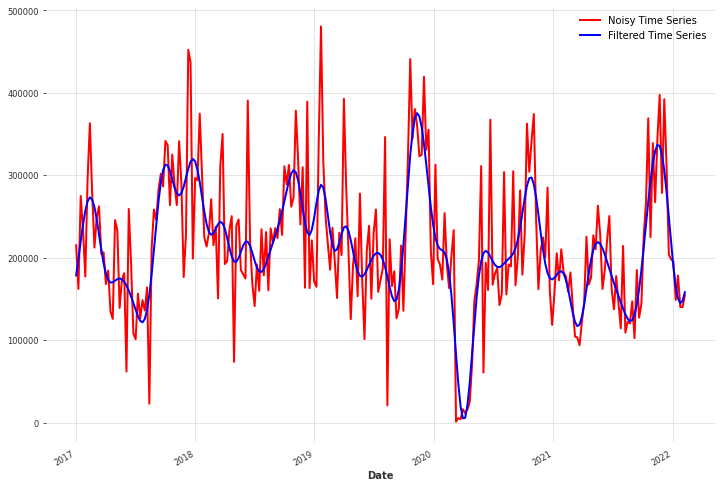

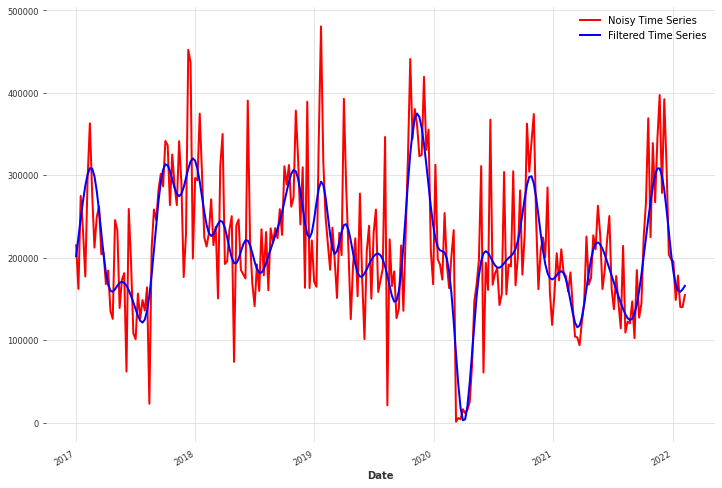

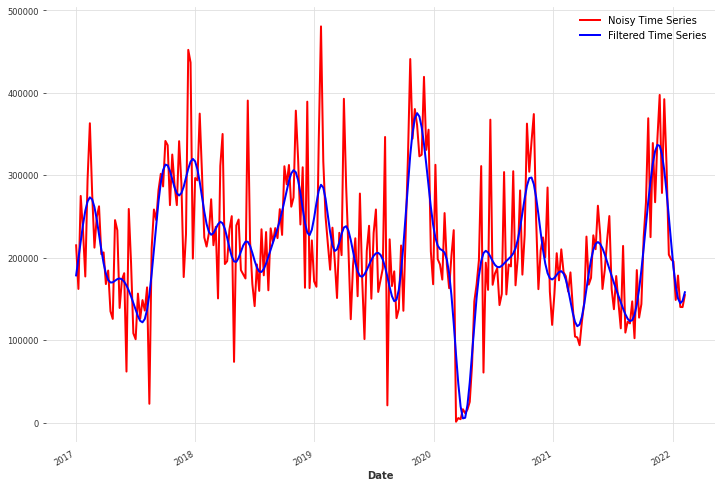

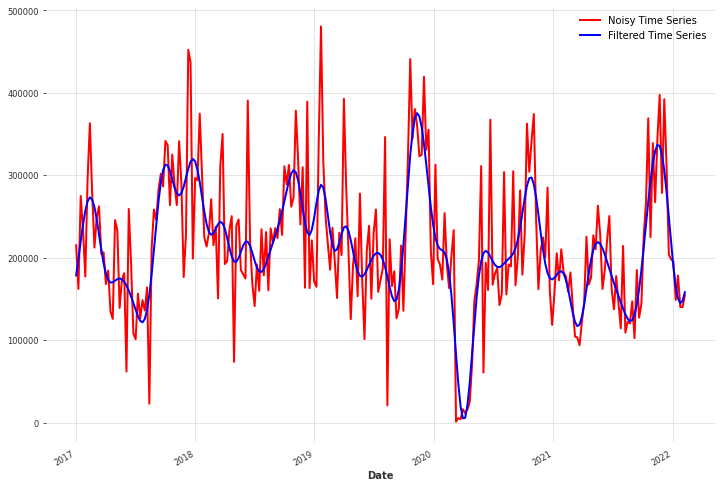

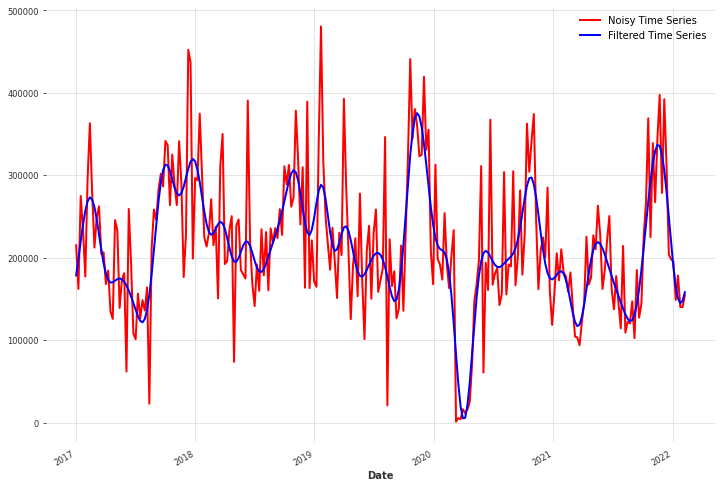

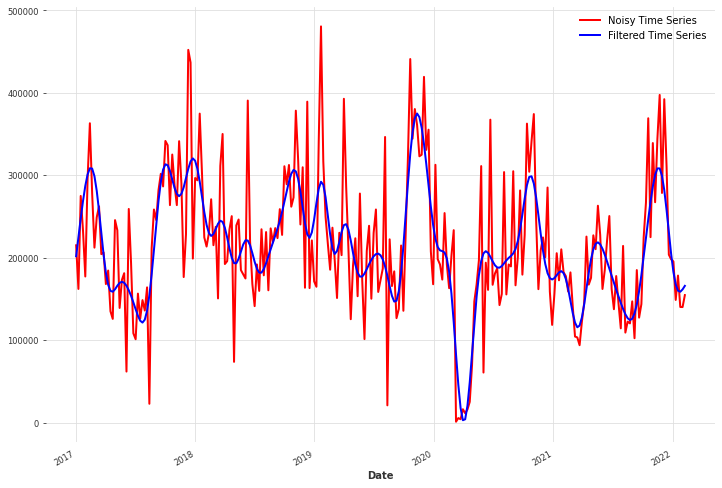

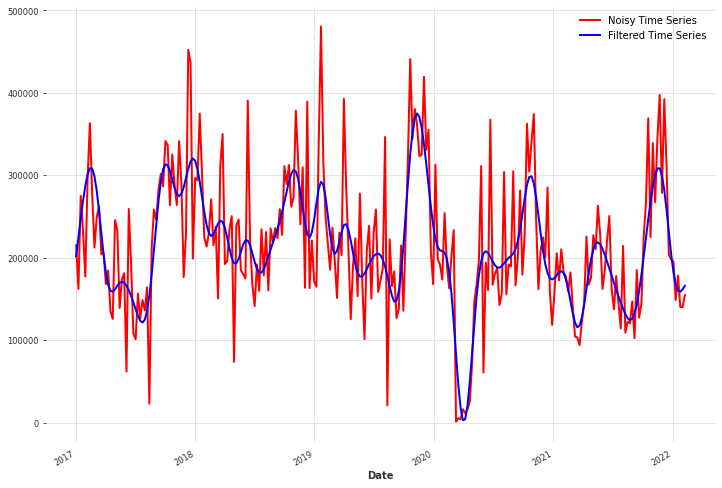

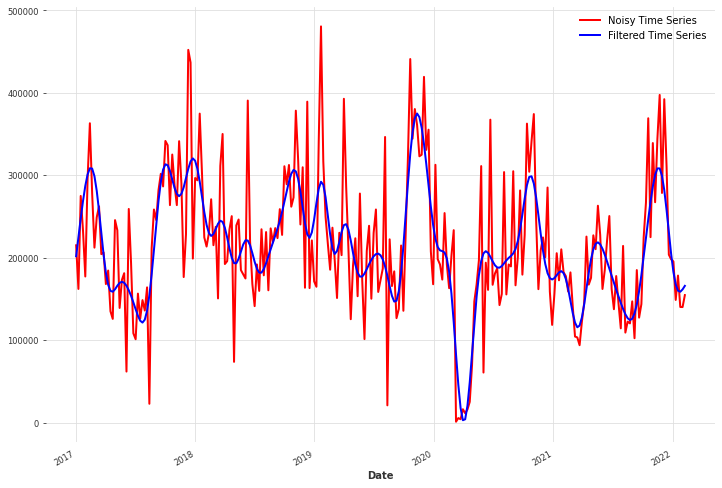

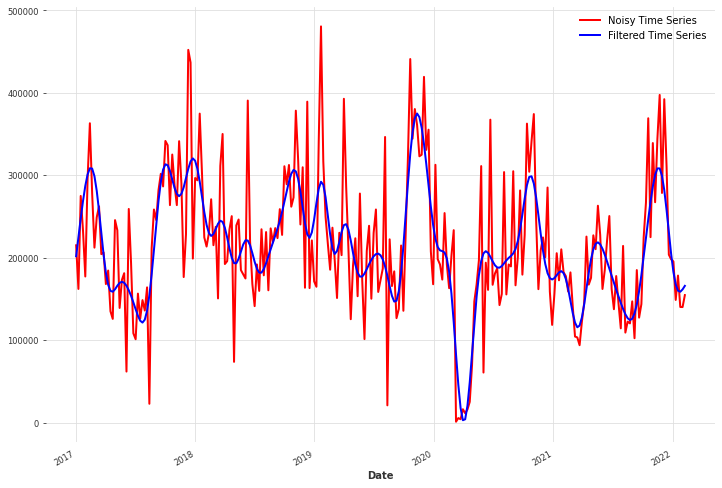

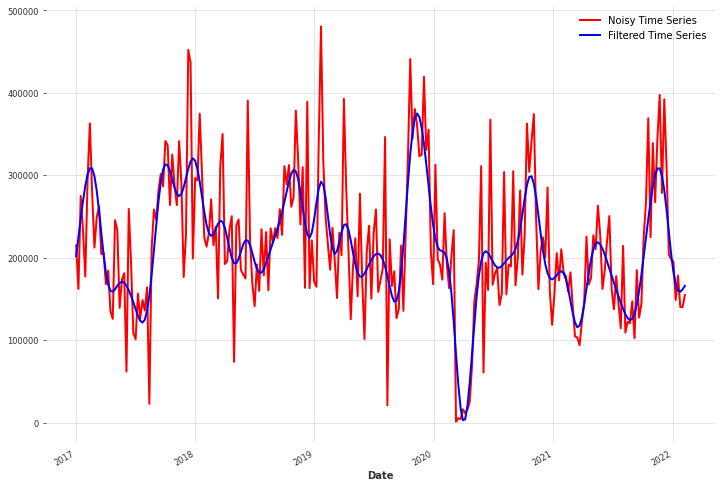

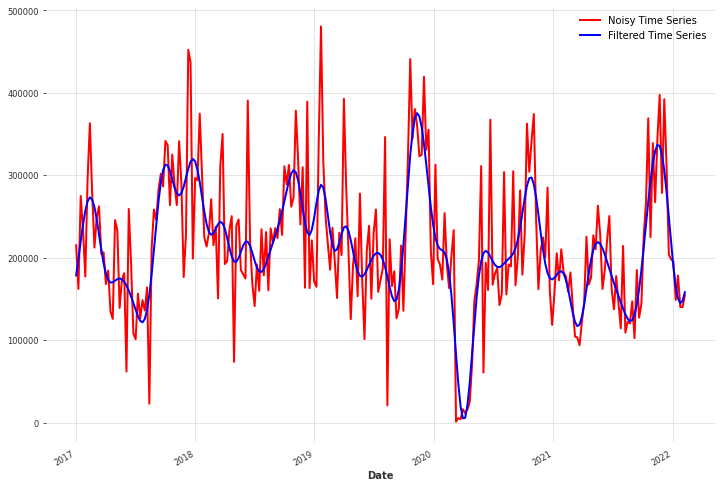

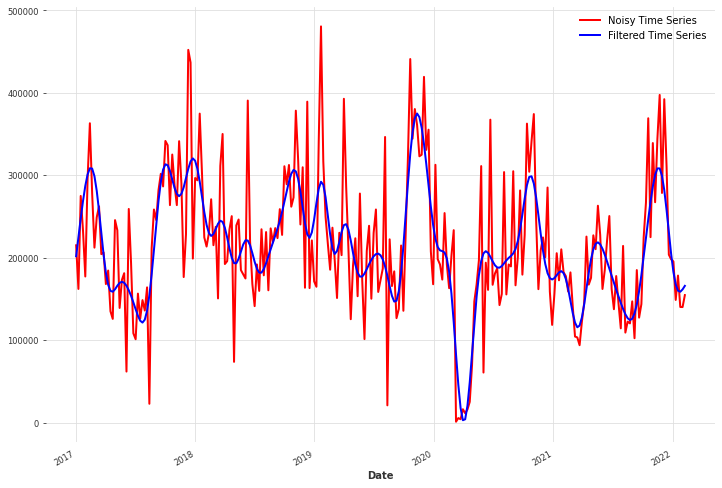

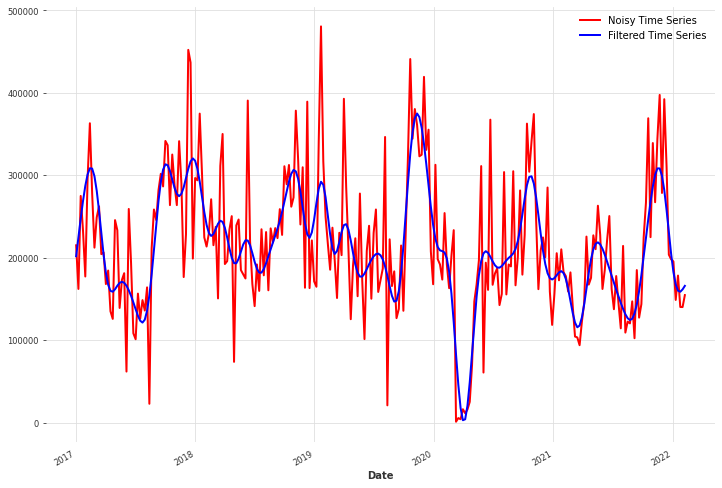

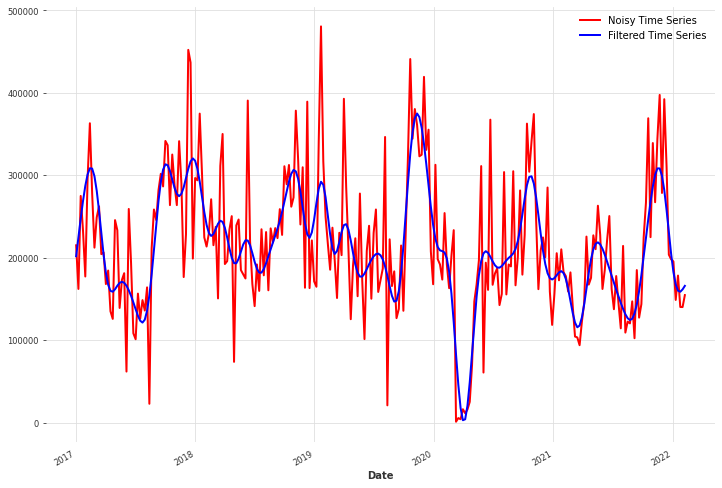

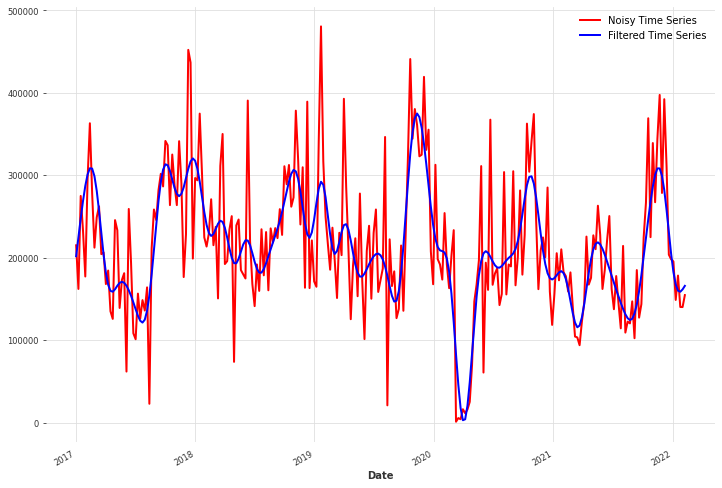

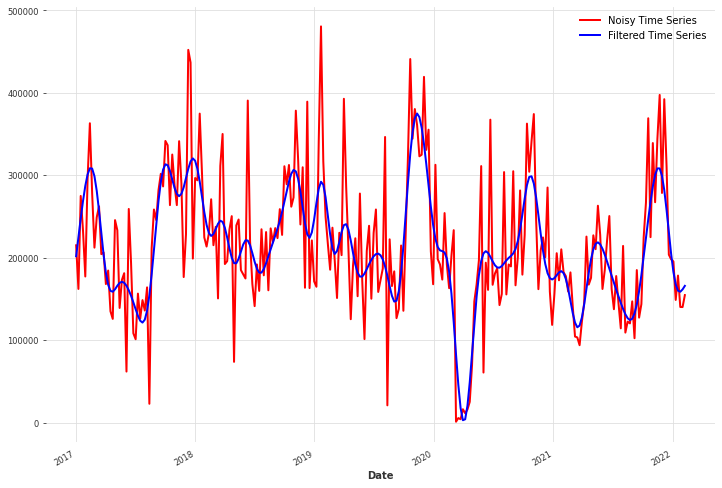

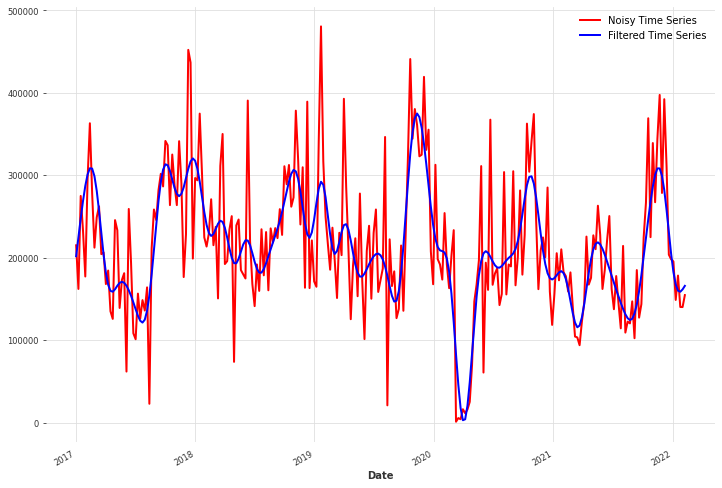

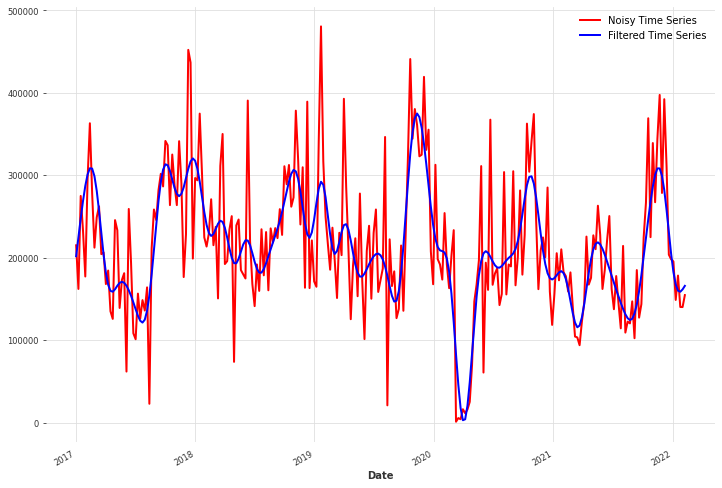

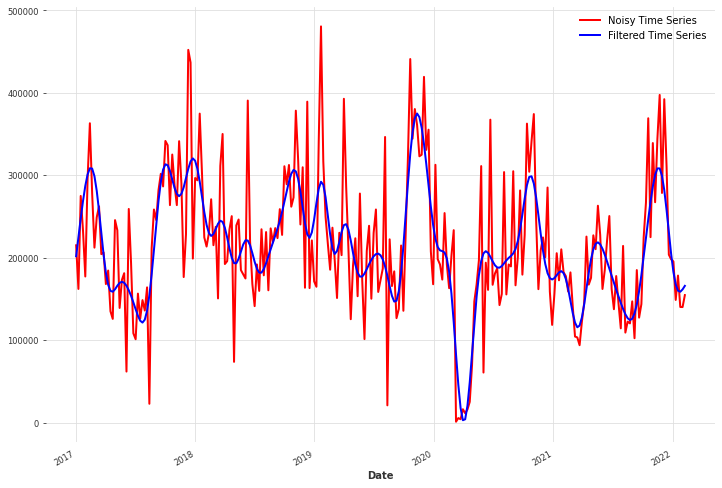

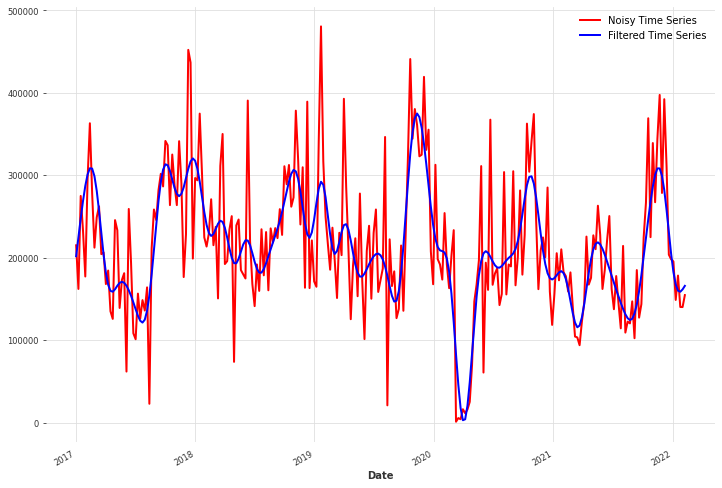

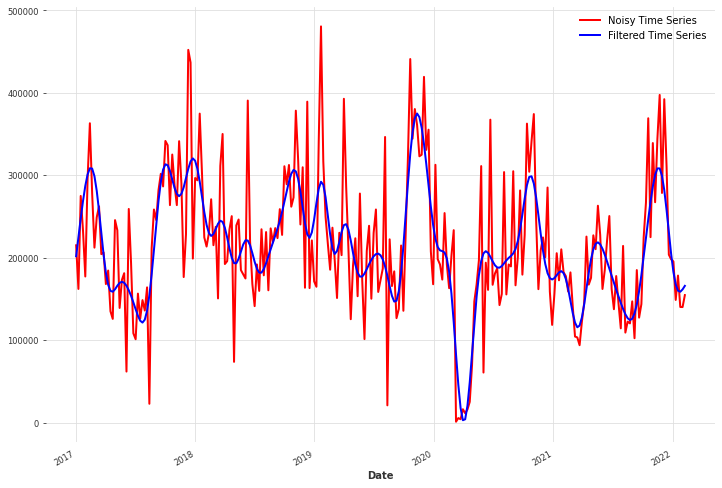

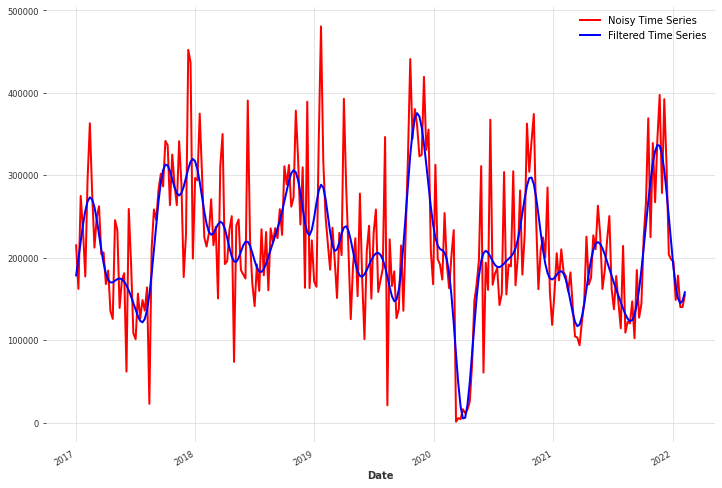

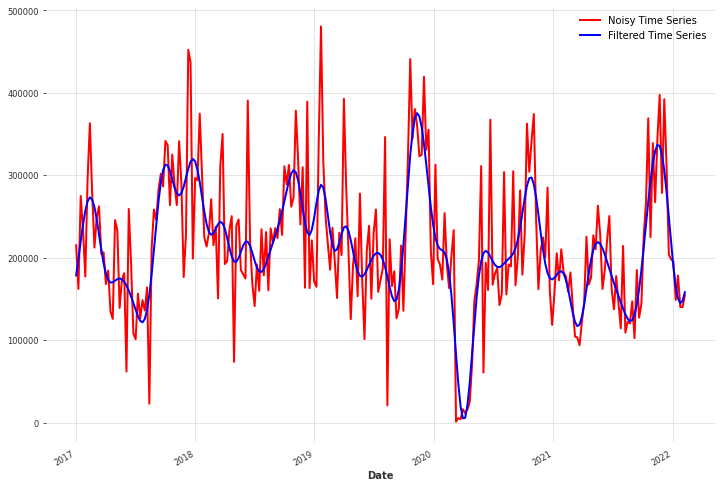

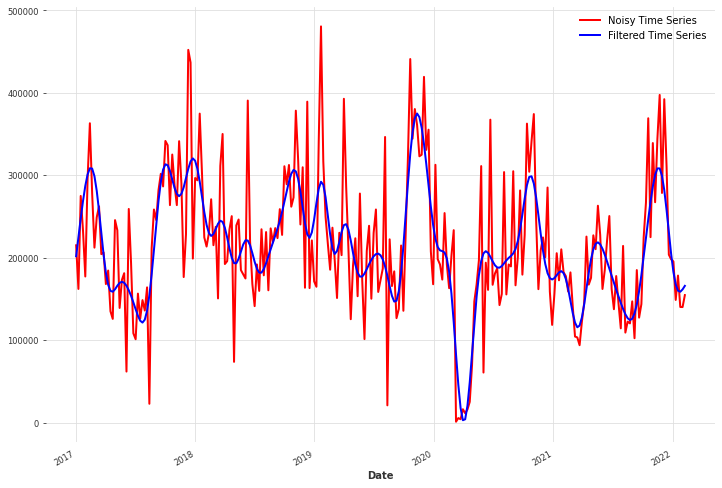

In [37]:
count = 0
for j in range(len(model_list_covar)):
    print ("running for Model :",model_list_covar[j])
    for i in range(4):

        periods = period_list[i]

        print ("Running of details :",periods)
        print (periods[0],periods[1],periods[2])

        # Split Data - Required column 
        train_data,val_data,benchmark_data,timeseries_input,regression_train_data,regression_val_data_split = call_timeseries('Sum_All_Variables','Sum_All_Variables_Benchmark',periods[0],
                                                    periods[1],periods[2])



#         model_orig = model_list_orig[j]

#         model_orig.fit(train_data)

#         if i <=2:
            
#             pred1 = model_orig.predict(n=12 )
#         else:
#             pred1 = model_orig.predict(n=10 )
#         # Calculate the loss off model
#         loss_model_orig = mae(val_data , pred1)
#         #Calculate the loss of bencmark model
#         loss_benchmark_orig = mae(val_data, benchmark_data)
#         # Calculate the loss off backtesting
#         # loss_backtesting = mae(val_data,pred_backtest)
#         # Print the loss function for benchmark data
#         print ("Benchmark Loss is :", loss_benchmark_orig) 
#         # Print the loss function for benchmark data
#         print ("Model without covariates Predict Loss is :", loss_model_orig)   
        
#         df_results.loc[count, 'Model_Name'] =model_list_covar[j]
#         df_results.loc[count, 'period'] = periods[0]
#         df_results.loc[count, 'loss_without_covar'] = loss_model_orig
#         df_results.loc[count, 'loss_benchmark'] = loss_benchmark_orig

        model = model_list_covar[j]

        model.fit(train_data, 
                         past_covariates=regression_train_data)

        if i <=2:
            
            pred = model.predict(n=12 )
        else:
            pred = model.predict(n=10 )

        # Calculate the loss off model
        loss_model_covariates = mae(val_data , pred)
        #Calculate the loss of bencmark model
        loss_benchmark = mae(val_data, benchmark_data)
        # Calculate the loss off backtesting
        # loss_backtesting = mae(val_data,pred_backtest)
        # Print the loss function for benchmark data
        print ("Benchmark Loss is :", loss_benchmark) 
        # Print the loss function for benchmark data
        print ("Model with covariates Predict Loss is :", loss_model_covariates)   
        df_results.loc[count, 'loss_with_covar'] = loss_model_covariates
        df_results.loc[count, 'train_series'] = 'Sum_All_Variables'
        df_results.loc[count, 'benchmark_series'] = 'Sum_All_Variables_Benchmark'
        count = count + 1

df_results

In [38]:
df_results.to_csv("All_models_sum_variables_covariates.csv")